# Исследование популярности компьютерных игр 

#  Описание проекта

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных:

-	Name — название игры
-	Platform — платформа
-	Year_of_Release — год выпуска
-	Genre — жанр игры
-	NA_sales — продажи в Северной Америке (миллионы проданных копий)
-	EU_sales — продажи в Европе (миллионы проданных копий)
-	JP_sales — продажи в Японии (миллионы проданных копий)
-	Other_sales — продажи в других странах (миллионы проданных копий)
-	Critic_Score — оценка критиков (максимум 100)
-	User_Score — оценка пользователей (максимум 10)
-	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Откроем предоставленную информацию и изучим данные

Осуществим импорт необходимых библиотек, откроем и изучим предоставленные данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
import numpy as np
import warnings

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Проверим таблицу на наличие дубликатов

In [3]:
games.duplicated().sum()

0

Проверим совпадение названия игры и платформы:

In [4]:
games.duplicated(subset = ['Name', 'Platform']).sum()

5

Количество совпадений не критично для анализа, оставим как есть

Получим общую информацию о таблице

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Из полученных данных мы видим:
- Во всех названиях столбцов присутствует верхний регистр, надо привести в нижний регистр;
- В графе Name и Genre по 2 пропуска (возможно это одни и те же строки);
- В графе Year_of_Release есть пропущенные значения и формат нужно исправить на целочисленный (пропущенные значения нам не так важны для анализа, поэтому можно заменить на "0");
- Пропуски в Rating заменим на 'undefined';
- Пропуски в Critic_Score, User_Score оставим не заполненными
- Добавим столбец с суммарными продажами

## Подготовка данных

### Переименуем столбцы

In [7]:
games.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [8]:
columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales', 
           'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
games.columns = columns

### Работа с пропусками

Проверим, соответствуют ли строки с пропусками в данных в столбцах 'name' и 'genre'

In [9]:
games[(games['name'].isnull())&(games['genre'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 659 to 14244
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             0 non-null      object 
 1   platform         2 non-null      object 
 2   year_of_release  2 non-null      float64
 3   genre            0 non-null      object 
 4   na_sales         2 non-null      float64
 5   eu_sales         2 non-null      float64
 6   jp_sales         2 non-null      float64
 7   other_sales      2 non-null      float64
 8   critic_score     0 non-null      float64
 9   user_score       0 non-null      object 
 10  rating           0 non-null      object 
dtypes: float64(6), object(5)
memory usage: 192.0+ bytes


Предположение подтвердилось - строки с пропусками соответствуют в данных столбцах. Заменим пропущенные значения на пустые строки

In [10]:
games.fillna(
    {"name" : " ", 
     "genre" : " "}
    , inplace=True
)

В столбце user_score нам нужно 'tbd' ('to be determined') заменить на NaN

In [11]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [12]:
games['user_score'] = games['user_score'].replace('tbd', 'NaN')
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'NaN', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Пропуски в Rating мы заменим на 'undefined'

In [13]:
games['rating'] = games['rating'].fillna('undefined')
games['rating'].value_counts()

undefined    6766
E            3990
T            2961
M            1563
E10+         1420
EC              8
RP              3
K-A             3
AO              1
Name: rating, dtype: int64

### Поменяем формат

Приведем данные в столбцах year_of_release и critic_score в целочисленный формат

In [14]:
games['year_of_release'] = games['year_of_release'].astype('Int64')
games['critic_score'] = games['critic_score'].astype(float)
games['user_score'] = games['user_score'].astype(float)

### Добавим столбец

Добавим столбец с суммарными продажами total_sales

In [15]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis = 1)
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,undefined,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,undefined,31.38


## Исследовательский анализ данных

### Посмотрим сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [16]:
platform_sales = games.pivot_table(index='year_of_release', values='total_sales', aggfunc=['sum','count'])
platform_sales

,sum,count
,total_sales,total_sales
year_of_release,,
1980,11.38,9
1981,35.68,46
1982,28.88,36
1983,16.80,17
1984,50.35,14
1985,53.95,14
1986,37.08,21
1987,21.70,16


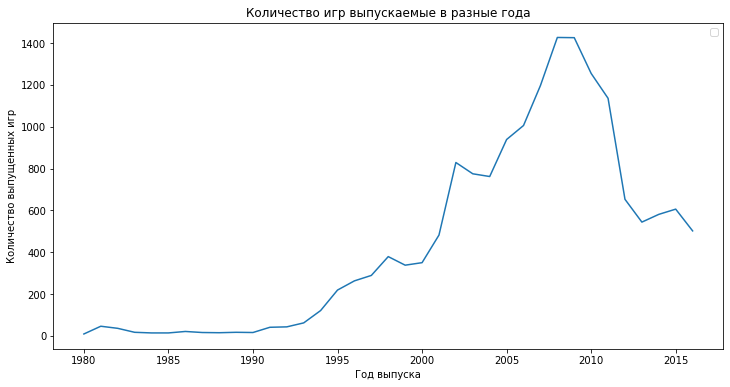

In [17]:
games_in_time = games.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=games_in_time)
plt.title("Количество игр выпускаемые в разные года")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')
plt.show()

Как мы видим из графика начав свой рост в 90е годы и достигнув пика в 2008 году выпуск игр пошел на спад. Считаю приемлимым взять в анализ данные начиная с 2012 года.

In [18]:
games_to_analize = games.loc[games['year_of_release'] >= 2012]
games_to_analize['platform'].value_counts()

PS3     493
PSV     411
3DS     396
PS4     392
X360    292
PC      250
XOne    247
PSP     173
WiiU    147
Wii      54
DS       31
Name: platform, dtype: int64

### Определим топ платформ 

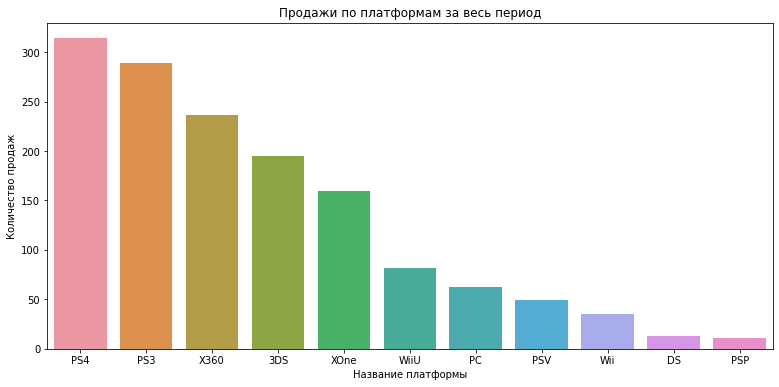

In [19]:
platform_of_games = games_to_analize.pivot_table(
    index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(13,6))
sns.barplot(x=platform_of_games.index,y=platform_of_games['total_sales'])
plt.title("Продажи по платформам за весь период")
plt.xlabel("Название платформы")
plt.ylabel("Количество продаж")
plt.show()

Как видно из графика самые популярные платформы это PS4, X360, PS3, 3DS, XOne.
Так как платформы X360, PS3, Wii, PSP уже потеряли свою актуальность, уберем их из списка анализируемых платформ и сосредоточим внимание на более актуальной информации

In [20]:
games_to_analize = games_to_analize[games_to_analize['platform'].isin(['PS4', '3DS','XOne','WiiU','PC','PSV','DS'])]  

Чтобы нам получить сводную таблицу и получать данные, напишем функцию

In [21]:
def platform_total_sale(name, data):
    pie = games[(games['platform'] == name) & (games['year_of_release'] > 2012)]
    total = pie.pivot_table(index = 'year_of_release', values='total_sales', aggfunc = 'sum').sort_values('year_of_release', ascending=False)
    return total

Построим таблицу по 5 самым востребованным платформам

In [22]:
top_5_platform = games_to_analize.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(5)
top_5_platform = top_5_platform.reset_index()
top_5_platform

,platform,total_sales
0,PS4,314.14
1,3DS,194.61
2,XOne,159.32
3,WiiU,82.19
4,PC,62.65


Визуализируем поведение платформ на отрезке времени в 5 лет

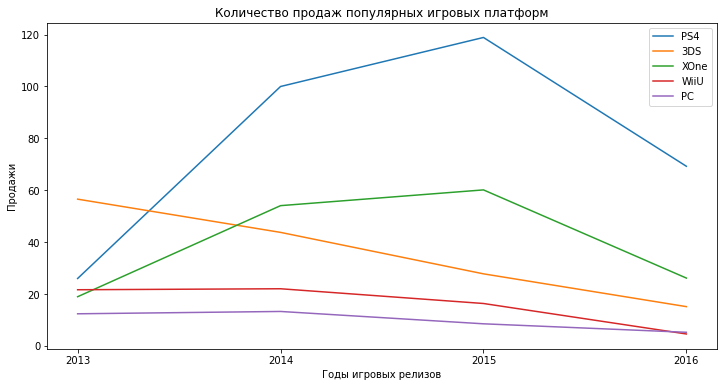

In [23]:
plt.figure(figsize=(12,6))
plt.title('Количество продаж популярных игровых платформ')
plt.xlabel('Годы игровых релизов')
plt.xticks(np.arange(2013,2017,1))
plt.ylabel('Продажи')

for i in list(top_5_platform['platform']):
    sns.lineplot(data=platform_total_sale(i,games_to_analize)['total_sales'], label=i)
    plt.legend()

<div class="alert alert-success">
<h2> Комментарий ревьюера 😊 v_2<a class="tocSkip"> </h2>
 
Чтобы скорректировать значения на оси Х, используй `plt.xticks(np.arange(2013,2017,1))` </div>
</div>

По данному графику мы видим, что в среднем платформа пользуется популярностью около 10 лет. Пик популярностью примерно приходится на середину жизненного цикла платформы. По графику видно, что популярность всех платформ падает. Но по прежнему высокие продажи у PS4, XOne и 3DS

### Сделаем разбивку по платформам и построим график "ящик с усами". Для этого необходимо сохранить наш Топ 5 в переменной

Так как больше 1.4 миллионов продаж скорее всего выброс в данных, поставим ограничение

In [24]:
top_5 = ['PS4', '3DS', 'WiiU', 'XOne','PC']
games_top_5_platforms = games_to_analize[games_to_analize['platform'].isin(['PS4', '3DS', 'WiiU', 'XOne','PC'])]
games_top_5_platforms = games_top_5_platforms[games_top_5_platforms['total_sales'] < 1.4]
games_top_5_platforms['total_sales'].describe()

count    1286.000000
mean        0.243554
std         0.299405
min         0.010000
25%         0.040000
50%         0.120000
75%         0.330000
max         1.390000
Name: total_sales, dtype: float64

Text(0, 0.5, 'Глобальные продажи')

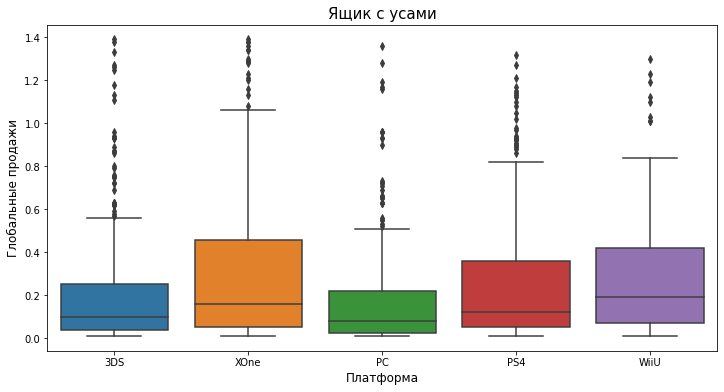

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data = games_top_5_platforms, x='platform', y='total_sales')
plt.title("Ящик с усами", fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи', fontsize=12)

Исходя из графика мы можем видеть, что медиана у всех платформ проходит ниже среднего. На первом месте по продажам платформа XOne, после WiiU, потом PS4, 3DS и PC на последних местах

Также рассмотрим все платформы

Text(0, 0.5, 'Глобальные продажи')

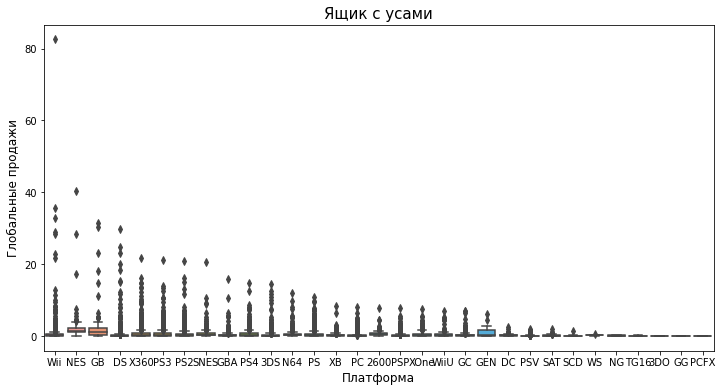

In [26]:
plt.figure(figsize=(12,6))
sns.boxplot(data = games, x='platform', y='total_sales')
plt.title("Ящик с усами", fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи', fontsize=12)

По графику мы можем видеть, что у первых трех на графике платформ есть много выбросов 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

Расчитаем корреляцию между оценками пользователей и продажами для платформы XOne

In [27]:
xone = games_to_analize[games_to_analize['platform'] == 'XOne']
xone['user_score'].corr(xone['total_sales'])

-0.06892505328279414

Построим диаграмму рассеяния

Text(0.5, 1.0, 'test')

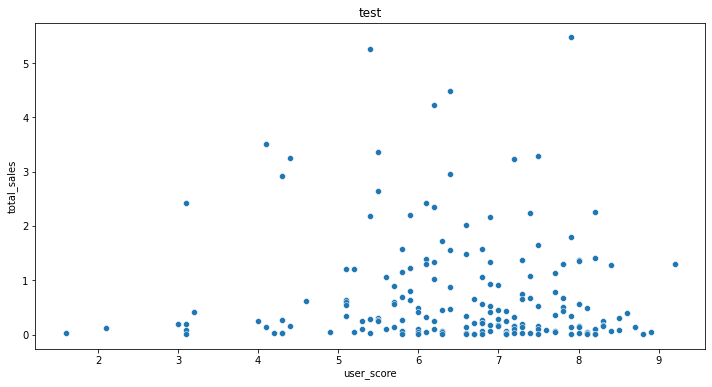

In [28]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=xone)
plt.title('test')

Построим диаграмму рассеяния по оценкам критиков

Text(0.5, 1.0, 'test')

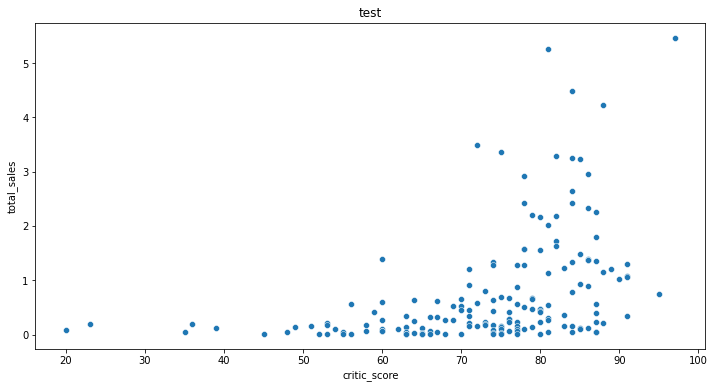

In [29]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=xone)
plt.title('test')

Расчитаем корреляцию между оценками критиков и продажами для платформы XOne

In [30]:
xone['critic_score'].corr(xone['total_sales'])

0.4169983280084017

Судя по графикам, оценки пользователей немного лучше оценок критиков!

Посмотрим, как влияют на продажи отзывы пользователей и критиков на примере платформы WiiU. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

In [31]:
wiiu = games_to_analize[games_to_analize['platform'] == 'WiiU']
wiiu['user_score'].corr(wiiu['total_sales'])

0.4002190202148617

Построим диаграмму рассеяния

Text(0.5, 1.0, 'test')

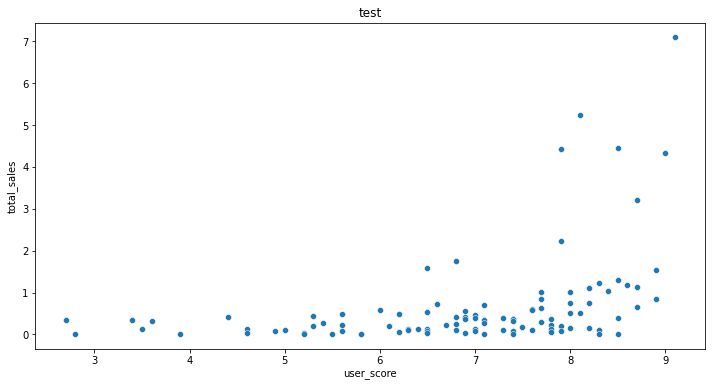

In [32]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=wiiu)
plt.title('test')

Построим диаграмму рассеяния на основе отзывов критиков

Text(0.5, 1.0, 'test')

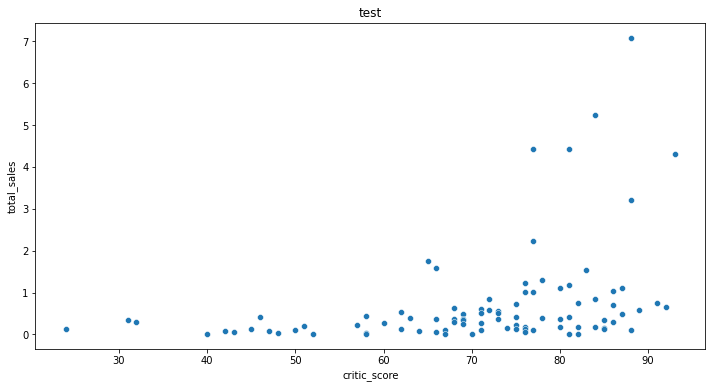

In [33]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=wiiu)
plt.title('test')

Расчитаем корреляцию между оценками пользователей и продажами для платформы WiiU

In [34]:
wiiu['critic_score'].corr(wiiu['total_sales'])

0.34837976012017485

Повторим наши процедуры и посмотрим, как влияют на продажи отзывы пользователей и критиков на примере платформы PS4. Построем диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами

In [35]:
ps4 = games_to_analize[games_to_analize['platform'] == 'PS4']
ps4['user_score'].corr(ps4['total_sales'])

-0.031957110204556376

Построим диаграмму рассеяния

Text(0.5, 1.0, 'test')

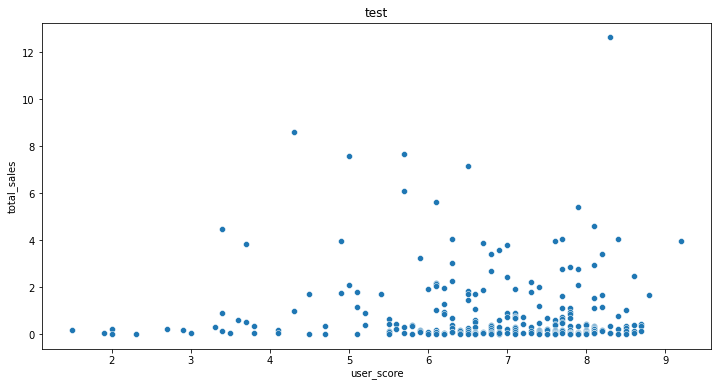

In [36]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=ps4)
plt.title('test')

Построим диаграмму рассеяния на основе отзывов критиков

Text(0.5, 1.0, 'test')

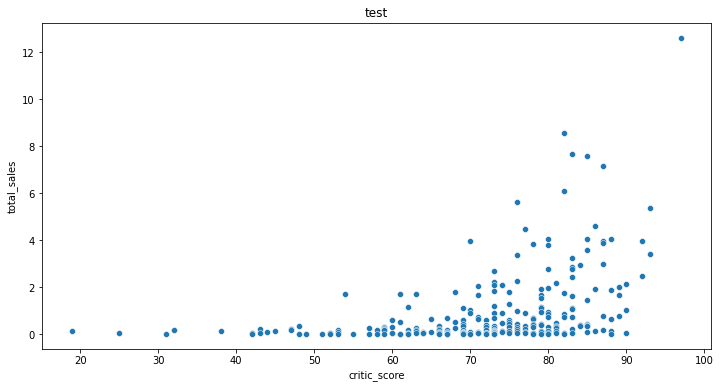

In [37]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4)
plt.title('test')

Корреляция между отзывами критиков и продажами

In [38]:
ps4['critic_score'].corr(ps4['total_sales'])

0.40656790206178095

Сделаем те же графики и расчеты для остальных платформ

In [39]:
games_to_analize['user_score'].corr(games_to_analize['total_sales'])

0.024744361388391978

In [40]:
games_to_analize['critic_score'].corr(games_to_analize['total_sales'])

0.3083045118607608

Text(0.5, 1.0, 'test')

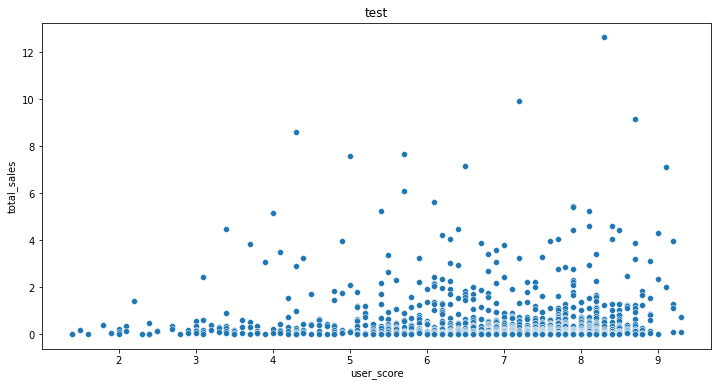

In [41]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='user_score', y='total_sales', data=games_to_analize)
plt.title('test')

Text(0.5, 1.0, 'test')

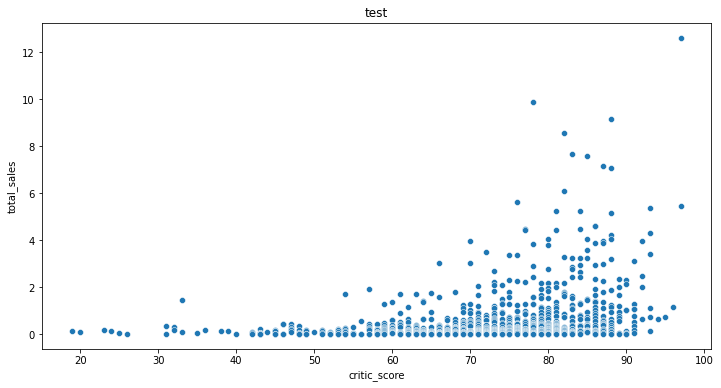

In [42]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='critic_score', y='total_sales', data=games_to_analize)
plt.title('test')

Из диаграмм и чистых цифр корреляции видно, что зависимости между продажами и отзывами пользователей почти нет или она отрицательная. А вот зависимость между продажами и отзывами критиков довольно сильная и стабильная (корреляция около 0.4 для полпулярных платформ и около 0.3 для всех платформ).

### Возьмем данные за актуальный период

Судя по тому, что средний жизненный цикл платформы составляет около 10 лет, для расчета показателей на 2017 год, нам следует выбрать период с 2012 по 2016 года. Потому что в 2017 году платформы начавшие свой жизненный цикл в 2012 году, будут переживать примерно половину от своего жизненного цикла.

In [43]:
platforms = games_to_analize.query('year_of_release >= 2012 and year_of_release <=2016')['platform'].unique()

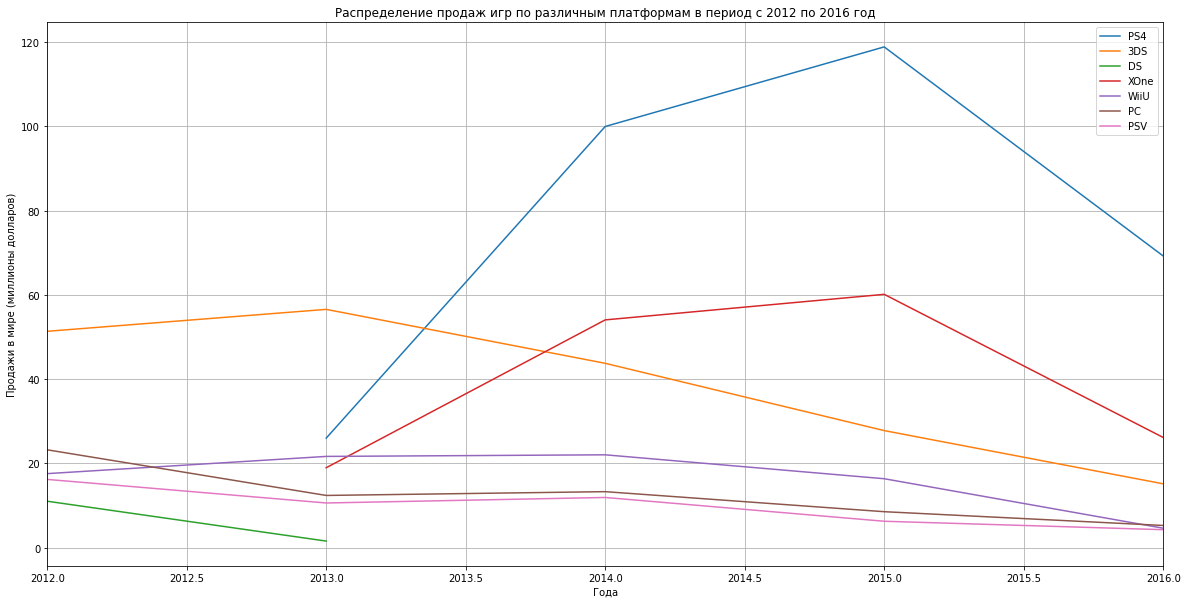

In [44]:
for current_platform in platforms:
    (
    games_to_analize.query('platform == @current_platform'). 
    groupby('year_of_release')['total_sales'].
    sum().
    plot(grid=True, figsize = (20,10))
    )
plt.xlim(2012, 2016)
plt.xlabel('Года')
plt.ylabel('Продажи в мире (миллионы долларов)')
plt.title('Распределение продаж игр по различным платформам в период с 2012 по 2016 год')
plt.legend(platforms)
plt.show()

Судя по графику мы можем сделать вывод, что 3 платформы останутся в 2017 году актуальными из нашего списка - PS4, XOne и 3DS. 
Также видно, что 2 платформы не так давно появились на рынке, а одна уже давно идет на спад, соответственно ее жизненный цикл подхожит к концу. Соответственно мы можем сделать вывод, что PS4 и XOne будут актуальными и потенциально прибыльными еще приблизительно 3-4 года. То есть на 2017 и 2019 годы можно рассчитывать на их потенциальную прибыльность.


### Рассчитаем прибыльность по жанрам

Выделим самые прибыльные, жанры с самыми высокими и самыми низкими продажами

<function matplotlib.pyplot.show(close=None, block=None)>

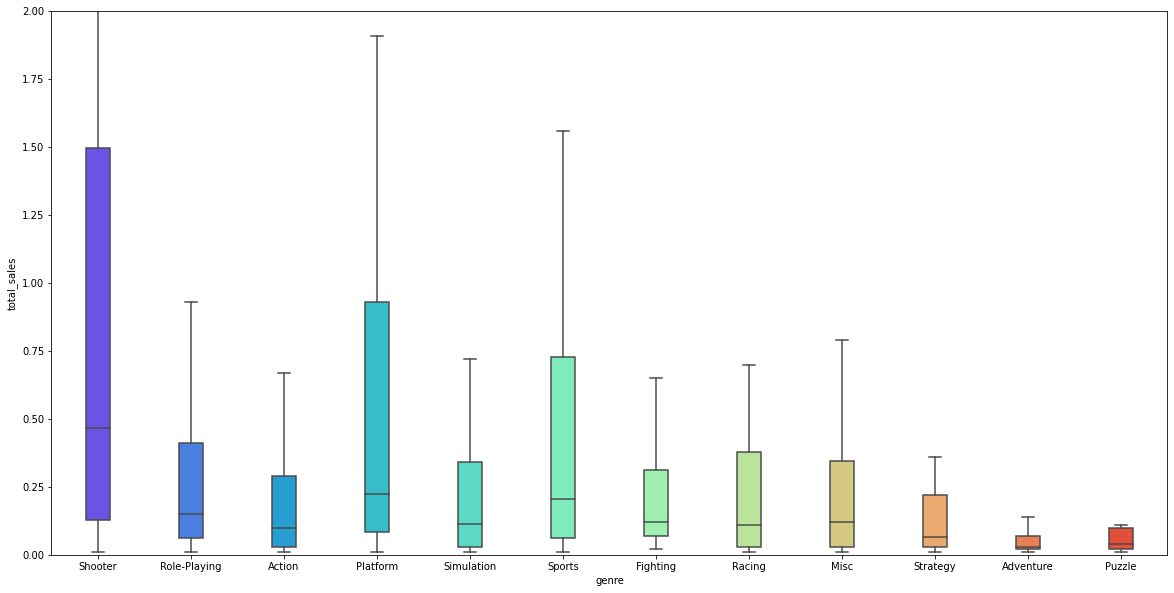

In [45]:
plt.figure(figsize=(20,10))
platforms_boxplot = sns.boxplot(x='genre',
                               y = 'total_sales',
                               palette = 'rainbow',
                               data = games_to_analize,
                               fliersize =4, 
                               width = 0.25, showfliers=False)
plt.ylim(0,2)
plt.show

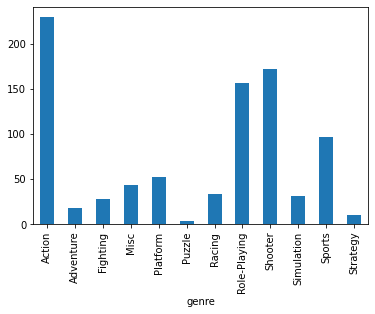

In [46]:
popularity_of_genres = games_to_analize.groupby(['genre'])['total_sales'].sum().plot(kind='bar')

Видно, что самый популярный жанр это Action. На втором месте Shooter, затем Role-playing. Менее популярны такие жанры как Sports, Platform, Misc, Racing, Fighting и Simulation. А самые последние места по популярности занимают такие жанры как Adventure, Strategy и Puzzle.

# Вывод

Быди проделаны следующие процедуры:
- для анализа были отобраны данные по играм, начиная с 2012 года
- были определены самые популярные платформы
- было выяснено, что в среднем платформа набирает обороты в первые 2 года и пользуется спросом в течении 8-10 лет
- были определены с5 самых попелярных платформ.  На первом месте по продажам платформа XOne, после WiiU, потом PS4, 3DS и DS на последних местах Выяснили, как влияют на продажи первых трех по популярности платформ отзывы пользователей и критиков. Построили диаграмму рассеяния и посчитали корреляцию между отзывами и продажами
- были отобраны данные за актуальный по нашему мнению период с 2012 по 2016 года. Был сделан вывод, что 3 платформы останутся в 2017 году актуальными из нашего списка - PS4, XOne и 3DS. Также видно, что 2 платформы не так давно появились на рынке, а одна уже давно идет на спад, соответственно ее жизненный цикл подхожит к концу. Выяснили, что PS4 и XOne будут актуальными и потенциально прибыльными еще приблизительно 3-4 года. То есть на 2017 и 2019 годы можно рассчитывать на их потенциальную прибыльность
- Определили, что самый популярный жанр это Action. На втором месте Shooter, затем Role-playing. Менее популярны такие жанры как Sports, Platform, Misc, Racing, Fighting и Simulation. А самые последние места по популярности занимают такие жанры как Adventure, Strategy и Puzzle.

## Составим портрет пользователя каждого региона

Определим для каждого региона(NA, EU, JP):
- Самые популярные платформы;
- Самые популярные жанры;
- Влияет ли рейтинг ESRB на продажи в отдельном регионе

Выберем период, который, как мы посчитали, актуальный!

### Определим самые популярные платформы

#### Для Cеверной Америки

In [47]:
top_platforms_na = games_to_analize.groupby(['platform'])['na_sales'].sum().sort_values(ascending=False).head(5)
top_platforms_na

platform
PS4     108.74
XOne     93.12
3DS      55.31
WiiU     38.10
PC       19.12
Name: na_sales, dtype: float64

Как мы выяснили самые популярные платформы в Северной Америке это PS4, XOne, 3DS, WiiU и PC

#### Для Европы

In [48]:
top_platforms_eu = games_to_analize.groupby(['platform'])['eu_sales'].sum().sort_values(ascending=False).head(5)
top_platforms_eu

platform
PS4     141.09
XOne     51.59
3DS      42.64
PC       37.76
WiiU     25.13
Name: eu_sales, dtype: float64

В Европе же на певром месте стоит PS4, на втором XOne и далее 3DS, PC, WiiU.

#### Для Японии

In [49]:
top_platforms_jp = games_to_analize.groupby(['platform'])['jp_sales'].sum().sort_values(ascending=False).head(5)
top_platforms_jp

platform
3DS     87.79
PSV     21.04
PS4     15.96
WiiU    13.01
DS       3.72
Name: jp_sales, dtype: float64

В Японии лидирует 3DS, следом PSV, PS4, WiiU и DS

### Определим самые популярные жанры

#### Для Cеверной Америки

In [50]:
top_na_genres_na = games_to_analize.groupby(['genre'])['na_sales'].sum().sort_values(ascending=False).head(5)
top_na_genres_na

genre
Action          86.19
Shooter         77.76
Role-Playing    50.27
Sports          38.78
Platform        21.03
Name: na_sales, dtype: float64

В Северной Америке лидирует жанр Action. На втором месте Shooter, на третьем Role-Playing, далее Sports и Platform

#### Для Европы

In [51]:
top__eu_genres_eu = games_to_analize.groupby(['genre'])['eu_sales'].sum().sort_values(ascending=False).head(5)
top__eu_genres_eu

genre
Action          83.71
Shooter         67.62
Sports          41.13
Role-Playing    40.25
Platform        18.24
Name: eu_sales, dtype: float64

В Европе лидирует Action, на втором месте Shooter, на третьем Sports, далее Role-Playing и Platform

#### Для Японии

In [52]:
top_jp_genres_jp = games_to_analize.groupby(['genre'])['jp_sales'].sum().sort_values(ascending=False).head(5)
top_jp_genres_jp

genre
Role-Playing    54.57
Action          34.46
Misc            10.53
Simulation       9.61
Platform         8.55
Name: jp_sales, dtype: float64

В Японии на первом месте жанр Role-Playing. Action занимает второе место, Misc, Simulation и Platform соответственно третье, четвертое и пятое места

### Определим влияет ли рейтинг ESRB на продажи в отдельном регионе

В нашем датасете использовани следующие рейтинги:
- Mature(M);
- Adults Only(AO);
- Everyone(E);
- Everyone10+(E10+);
- Early Childhood (EC);
- Rating Pending (RP);
- Teen (T)

#### Для Cеверной Америки

In [53]:
esrb_na = games_to_analize.groupby(['rating'])['na_sales'].agg([sum, lambda x: sum(x)/len(x)])
esrb_na.columns = ['total_sum', 'sum_per_game']
esrb_na

,total_sum,sum_per_game
rating,,
E,66.62,0.262283
E10+,40.63,0.192559
M,106.53,0.363584
T,39.97,0.149142
undefined,76.21,0.089870


Самым продаваемыми стали Mature(M), затем игры без рейтинга, Everyone(E) занимают третье место, потом Everyone10+(E10+) и Teen(T)

#### Для Европы

In [54]:
esrb_eu = games_to_analize.groupby(['rating'])['eu_sales'].agg([sum, lambda x: sum(x)/len(x)])
esrb_eu.columns = ['total_sum', 'sum_per_game']
esrb_eu

,total_sum,sum_per_game
rating,,
E,70.74,0.278504
E10+,31.14,0.147583
M,103.98,0.354881
T,36.35,0.135634
undefined,70.89,0.083597


В Европе лидирует Mature(M), игры без рейтинга на втором месте, затем Everyone(E), следом Teen(T) и Everyone10+(E10+)

#### Для Японии

In [55]:
esrb_jp = games_to_analize.groupby(['rating'])['jp_sales'].agg([sum, lambda x: sum(x)/len(x)])
esrb_jp.columns = ['total_sum', 'sum_per_game']
esrb_jp

,total_sum,sum_per_game
rating,,
E,24.36,0.095906
E10+,7.63,0.036161
M,9.15,0.031229
T,15.37,0.057351
undefined,85.35,0.100649


В Японии же на первом месте стоят игры без рейтинга, затем Everyone(E), за ним Teen (T), Mature(M) и Everyone10+(E10+)

# Вывод

На данном этапе для пользователя каждого региона (NA, EU, JP) были определены:

- Самые популярные платформы (топ-5). Если посмотреть на доли продаж по конкретным платформам, то видно, что в Северной Америке самые популярные платформы это PS4, XOne, 3DS, WiiU и PC. В Европе же на певром месте стоит PS4, на втором XOne и далее 3DS, PC, WiiU. В Японии лидирует 3DS, следом PSV, PS4, WiiU и DS.
Если посмотреть на доли продаж по конкретным жанрам игр, то видно, что в Северной Америке на первом месте жанр Action. На втором месте Shooter, на третьем Role-Playing, далее Sports и Platform. В Европе лидирует Action, на втором месте Shooter, на третьем Sports, далее Role-Playing и Platform. В Японии на первом месте жанр Role-Playing. Action занимает второе место, Misc, Simulation и Platform соответственно третье, четвертое и пятое места.
Также было выяснено, что рейтинг ESRB влияет на продажи в отдельном регионе. Было выяснено, что самыми продаваемыми в Северной Америке и в Европе являются игры в категории Mature (M), затем игры без рейтинга, затем Everyone (E), и затем меняются местами игры в категории Everyone 10+ (E10+) и Teen (T). В Японии на первом месте стоят игры без рейтинга, затем Everyone(E), за ним Teen (T), Mature(M) и Everyone10+(E10+)

## Проверка гипотез

Проверим следущие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

Нулевая гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза - Средние пользовательские рейтинги платформ Xbox One и PC различны

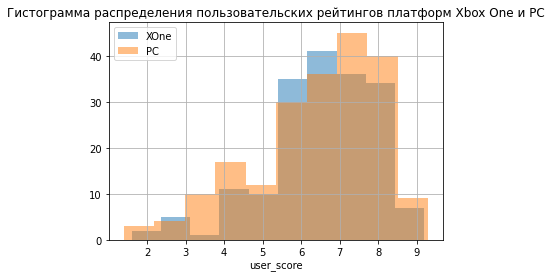

In [56]:
two_platforms = ['XOne','PC']
for platform in two_platforms:
    games_to_analize.loc[games_to_analize['platform'] == platform]['user_score'].hist(bins=10, alpha = 0.5, label=platform)
plt.xlabel('user_score')
plt.title('Гистограмма распределения пользовательских рейтингов платформ Xbox One и PC')
plt.legend()

In [57]:
(games_to_analize.loc[games_to_analize['platform'] == 'XOne', 'user_score']).mean()

6.521428571428572

In [58]:
(games_to_analize.loc[games_to_analize['platform'] == 'PC', 'user_score']).mean()

6.428640776699029

In [59]:
data1 = games_to_analize.loc[games_to_analize['platform'] == 'XOne', 'user_score'].dropna()
data2 = games_to_analize.loc[games_to_analize['platform'] == 'PC', 'user_score'].dropna()
alpha = 0.05

results = st.ttest_ind(
    data1,
    data2,
    equal_var = False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 0.5489537965134912
Не удалось отвергнуть нулевую гипотезу


Вывод - у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются

Теперь разберемся с жанрами

Нулевая гипотеза - Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза - Средние пользовательские рейтинги жанров Action и Sports различны

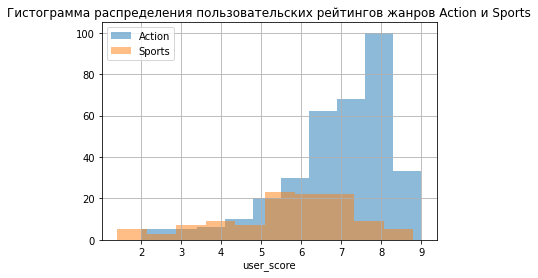

In [60]:
two_genres = ['Action','Sports']
for genre in two_genres:
    games_to_analize.loc[games_to_analize['genre'] == genre]['user_score'].hist(bins=10, alpha = 0.5, label=genre)
plt.xlabel('user_score')
plt.title('Гистограмма распределения пользовательских рейтингов жанров Action и Sports')
plt.legend()

In [61]:
(games_to_analize.loc[games_to_analize['genre'] == 'Action', 'user_score']).mean()

6.884660766961652

In [62]:
(games_to_analize.loc[games_to_analize['genre'] == 'Sports', 'user_score']).mean()

5.658928571428571

In [63]:
data3 = games_to_analize.loc[games_to_analize['genre'] == 'Action', 'user_score'].dropna()
data4 = games_to_analize.loc[games_to_analize['genre'] == 'Sports', 'user_score'].dropna()
alpha = 0.05

results = st.ttest_ind(
    data3,
    data4,
    equal_var = False)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

p-value: 2.1485834461972547e-11
Отвергаем нулевую гипотезу


Вывод - у нас есть основания пологать, что средние пользовательские рейтинги жанров Action и Sports значимо различаются

# Вывод

На данном этапе мы проверили 2 гипотезы. Проверка первой показала, что у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются. Проверка второй гипотеза показала, что у нас есть основания пологать, что средние пользовательские рейтинги жанров Action и Sports значимо различаются

# Общий вывод по работе

В этой работе были проведены следующие шаги:

1Для ответа на поставленную задачубыли проделаны следующие шаги:

1) В 1 шаге мы ознакомились с данными:

Определили, что нужно перевести название столбцов в нижний регистр, поменять типы данных в некоторых столбцах, добавить столбец с общим количесвтом продаж по датасету.

2) Во 2 шаге были подготовлены предоставленные данные для анализа:

Название всех столбцов было приведено к нижнему регистру, были исправлены типы данных в некоторых столбцах (в столбцах year_of_release и user_score), были исправлены аномалии в данных (значения tbd в столбце user_score были заменены на nan), была произведена работа с пропусками.

3) В шаге 3 было рассмотрено:

Сколько игр выпускалось в разные годы и были отсечены года, не релевантные для дальнейшего анализа (до 1996 года).
Как менялись продажи по платформам. Были выбраны платформы с наибольшими суммарными продажами (PS2, X360, PS3, Wii, DS) и построены распределения их прибыльности по годам. Был сделан вывод, что обычно платформам нужно 1-2 года, чтобы набрать популярность и что средний цикл их жизни около 8-10 лет (примерно к середине этого срока - то есть лет через 5 - на рынке появляется что-то другое и начинает отвоевывать у первой платформы популярность).
Был выделен актуальный период рассмотрения данных, на основе которого можно будет сделать прогноз на 2017 год (это период с 2012 по 2016 год). К 2014-2015 году практически все платформы, которые мы рассматриваем в данном периоде, уже подходят к логическому концу их жизненного цикла, кроме двух платформ -  PS4 и XOne, и в 2017-2019 годы можно рассчитывать на их потенциальную прибыльность.

Для трех популярных платформ были посчитаны корелляции между прибылью и рейтингами пользователей, и между прибылью и рейтингами критиков, также для этих параметров были построены диаграммы рассеяния.
Было рассмотренно общее распределение игр по жанрам. По суммарным продажам резко выделяется жанр Action. На втором месте Sports, затем Shooter. Менее популярны такие жанры как Role-playing, Misc, Racing, platform, Simulation и Fighting. Эти 4 жанра сильно выделяются на общем фоне остальных жанров, которые коллеблются между 10-75 мл долларов по суммарным продажам. Самыми не прибыльными являются жанры Puzzle и Strategy.

4) В шаге 4 для пользователя каждого региона (NA, EU, JP) были определены:

Самые популярные платформы (топ-5). Если посмотреть на доли продаж по конкретным платформам, то видно, что во всех трех странах среди лидеров выделяяется PS2. X360 также в тройке лидеро в Северной Америке и Европе, но не в Японии.
Если посмотреть на доли продаж по конкретным жанрам игр, то видно, что во всех трех регионах популярным является жанр Action, Sports и Shooter, в Северной Америке и Европе также популярны жанры Misc и Racing, а жанр Platform входит в топ только в Японии.
Также было выяснено, что рейтинг ESRB влияет на продажи в отдельном регионе. Было выяснено, что самыми продаваемыми во всех регионах являются игры в категории Everyone (E), затем в Северной Америке и Японии идут Teen (T) и Mature (M), а Европе наоборот Mature (M) затем Teen (T).

5) И на 5-ом шаге были проверены две гипотезы:

Проверка первой показала, что у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются. Проверка второй гипотеза показала, что у нас есть основания пологать, что средние пользовательские рейтинги жанров Action и Sports значимо различаются